# Part 1 ‑ Exploratory data analysis

I have a json file that contains simulated timestamps of user logins in a particular geographic location. My objective for Part 1 is to find interesting patterns in the resulting time series that characterize the underlying demand. 

In [1]:
# Import relevant packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [48]:
# Load json file with the user logins 
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [16]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [17]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


There are 93,142 recorded logins, however, only 92,265 login are unique. Next, I aggregate this information for every user across 15 minute intervals to get a better sense of when a demand occurs and why. 

In [49]:
# Set index of the date frame for full timestamp
logins['count'] = 1
logins_x = logins.set_index(pd.DatetimeIndex(pd.to_datetime(logins['login_time']))).drop('login_time', axis=1)

# Resample the index for 15min increments
logins_15min = logins_x.resample('15T').sum().fillna(0)
logins_15min['interval_time'] = pd.Series(logins_15min.index.values).dt.time.values

# Group by time of day
logins_15min_agg = logins_15min.groupby('interval_time', as_index=True).sum()
logins_15min_agg.head()

,count
interval_time,
00:00:00,1439
00:15:00,1547
00:30:00,1525
00:45:00,1482
01:00:00,1549


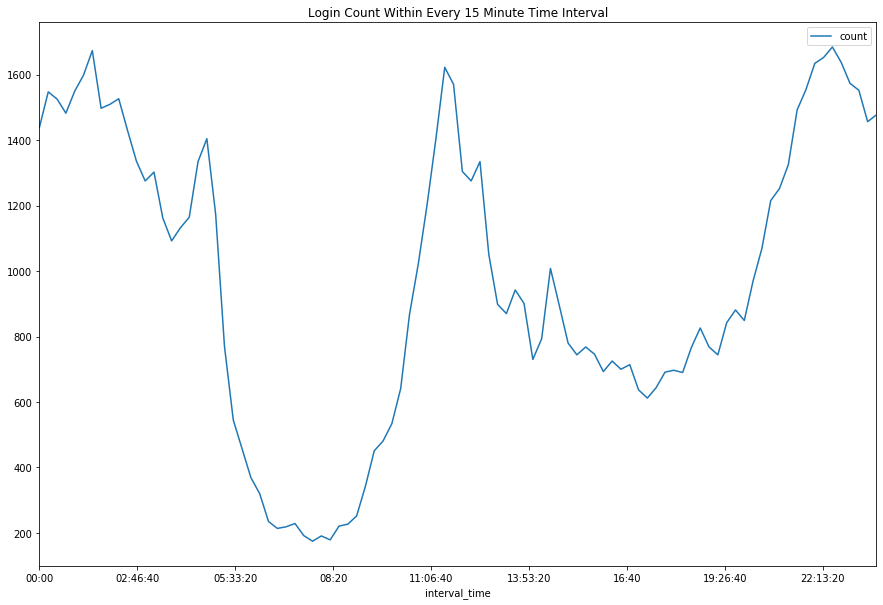

In [51]:
logins_15min_agg.plot(figsize=(15,10), title ='Login Count Within Every 15 Minute Time Interval')

Looking at the plot, the login traffic usually drops in the morning when most people are likely heading out to work or busy with morning activities. Traffic logins also has a slow drop in the evening time around 5:00PM but not as much of a significant drop compared to the morning. These drops occur during the times when everyone is likely commuting to and from work. The activity peaks during lunchtime around 12 pm and late night before people go to sleep between 10:30 pm to 1:30 pm.

But how does this pattern look for each day of the week for some patterns?

In [53]:
# Resample the index for day of the week increments
logins_15min_dow = logins_15min
logins_15min_dow['day_of_week'] = pd.Series(logins_15min.index.values).dt.dayofweek.values

# Group by time of day
logins_15min_dow_agg = logins_15min_dow.groupby(['interval_time', 'day_of_week'], as_index=False).sum()
logins_15min_dow_agg.head()

,interval_time,day_of_week,count
0,00:00:00,0,126
1,00:00:00,1,147
2,00:00:00,2,158
3,00:00:00,3,214
4,00:00:00,4,237


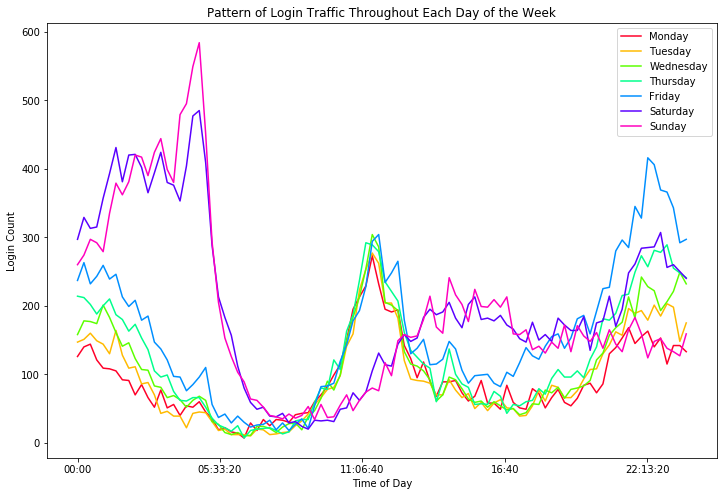

In [63]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sns.lineplot('interval_time', 'count', hue='day_of_week', data=logins_15min_dow_agg, palette="gist_rainbow")
_ = plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Pattern of Login Traffic Throughout Each Day of the Week')
_ = plt.xlabel('Time of Day')
_ = plt.ylabel('Login Count')

Weekdays and weekends have traffic login patterns that oscillates aganist each other. For example, most users tend to login early hours during the weekend, while not so much during the weekdays. There is a significant increase of login attempts around lunchtime during the weekdays, but this is not true for the weekends. One interesting note to mention is that Friday is the only day of the week with the most login traffic during late night after 11:00PM.

***

# Part 2 ‑ Experiment and metrics design

This second part is mostly commentary answering questions regarding the following scenario. 

**Scenario:** <br>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. <br>

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

**Questions:**
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Provide details on:
 * how you will implement the experiment?<br>
 * what statistical test(s) you will conduct to verify the significance of the observation?<br>
 * how you would interpret the results and provide recommendations to the city operations team along with any caveats?

A good metric to evaluate the effectiveness of reimbursement policy is to take compare the means of number of available driver partners (or alternatively customer waiting times) with and without the reimbursement policy for each city.

A practical experiment to verify the effectiveness of the propose policy is to conduct something similar to a random control trail:

* **First Step:** calculate the baseline mean of available drivers throughout a given time period. Before the reimbursement policy is implemented, we need to collect different random samples as the control group throughout the week:<br>
> $C_g$ number of drivers from Gotham available in Metropolis. <br> 
$C_m$ number of drivers from Metropolis available in Gotham. <br>

* **Second Step:** Implement the reimbursement policy and collect another random sample of available drivers from each city as the experiment group and calculate the mean available drivers for each day during a given time period:<br>
>$R_g$ number of drivers from Gotham in Metropolis after reimbursement policy. <br>
$R_m$ number of drivers from Metropolis in Gotham after reimbursement policy.

* **Third Step:** Calculate the two sample t-test to see if there is a statistically significant difference between the control group and experiment group. The null hypothesis is that there is no difference in means for treatment vs control across towns and times. The alternative hypothesis is that there is a difference in means. A significance level is picked, say 5% and the hypothesis is checked against the drawn samples for reaching a conclusion.

Another experiment design to measure the effectiveness of the reimbursement policy is to conduct a cohort study. To do this, first randomly select drivers from Gotham and Metropolis. As a baseline count how many of the drivers cross the toll bridge to the other city before the policy has implemented. Then soonafter implement the policy, and count those same drivers randomly selected from before to see how many new drivers have crossed the toll bridge to go to the other city. 


***

# Part 3 ‑ Predictive modeling of Rider Retention

I have a sample dataset for a cohort of riders for trips taken. The aim is to build a model that predicts whether a user will take at least one trip in a 30 day interval and to understand the most important predictors for that.

In [68]:
with open('ultimate_data_challenge.json') as f: 
    riders_json=json.load(f)

df= pd.DataFrame(riders_json)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Some of the rows have few values missing such as `avg_rating_by_driver` , `avg_rating_of_driver`, and `phone`. Dropping  NaN values of `avg_rating_of_driver`, which is the average rating of driver, will result in a loss of fifth of the dataset. To prevent this, the missing values will impute with mean for both average rating by/of driver. As for missing values in the `phone` feature, which is the type of phone used by the user, add a categorical variable called 'UNKNOWN'.

In [70]:
# Impute missing values 
df_clean= df
df_clean['avg_rating_by_driver']= df_clean['avg_rating_by_driver'].fillna(df_clean['avg_rating_by_driver'].mean())
df_clean['avg_rating_of_driver']= df_clean['avg_rating_of_driver'].fillna(df_clean['avg_rating_of_driver'].mean())
df_clean['phone']=df_clean['phone'].fillna('unknown')
df_clean['signup_date']=pd.to_datetime(df_clean['signup_date'])
df_clean['last_trip_date']=pd.to_datetime(df_clean['last_trip_date'])

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Next step is to build the response variable column 'y' to find users that are active in the 6th month (basically any rider who made atleast one trip in the 6th month)

In [71]:
# Function to build the response variable 
def get_y(row):
    signup= row['signup_date']
    start = signup+pd.DateOffset(months=5)
    end= signup+pd.DateOffset(months=6)
    last= row['last_trip_date']
    if last > start and last <= end:
        return True
    else:
        return False
    
y= df_clean.apply(get_y, axis=1)

In [72]:
print('Number of users that are active in 6th month: {0}'.format(np.sum(y)))

Number of users that are active in 6th month: 11711


Next is to build the feature matrix:

In [74]:
X_start= df_clean[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                     'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

X_cat= pd.get_dummies(df_clean[['city', 'phone', 'ultimate_black_user']])

X = pd.concat([X_start, X_cat], axis=1)

X.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,ultimate_black_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,phone_unknown
0,3.67,5.0,4.7,1.10,15.4,4,46.2,True,0,1,0,0,1,0
1,8.26,5.0,5.0,1.00,0.0,0,50.0,False,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,False,1,0,0,0,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,True,0,1,0,0,1,0
4,3.13,4.9,4.4,1.19,11.8,14,82.4,False,0,0,1,1,0,0


A simple Logistic Regression classifier since this is a classification problem. First we split data in train/test sets and then use K-Fold crossvalidation to decide on Regularization Parameter.

In [75]:
from sklearn.model_selection import train_test_split

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Hyper-parameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#the grid of parameters to search over
Cs = [0.001, 0.1, 1., 10.]

parameters = {'C':Cs}

clf = LogisticRegression(solver='liblinear')

cv_grid = GridSearchCV(clf, parameters, cv=5, scoring=make_scorer(accuracy_score), iid=True)
cv_grid.fit(X_train, y_train)
print(cv_grid.best_params_, cv_grid.best_score_)
print(accuracy_score(cv_grid.predict(X_test), y_test))

{'C': 1.0} 0.7762285714285714
0.7761333333333333


In [77]:
cv_grid.best_estimator_.coef_

array([[-3.83897959e-02, -1.37799636e-01, -3.63507951e-02,
        -1.12941552e-01,  4.36291200e-03,  9.73785105e-02,
        -4.04813493e-04,  6.90531990e-01, -7.35763129e-01,
         4.73840754e-01, -2.32871691e-01, -5.88392681e-01,
         3.64157874e-01, -2.70559258e-01]])

In [78]:
lr_best_params = dict(zip(X.columns.tolist(), cv_grid.best_estimator_.coef_[0].tolist()))
lr_best_params_s = sorted(lr_best_params, key=lambda x: abs(lr_best_params[x]), reverse=True)
pd.DataFrame({'feature_name': lr_best_params_s, 'feature_coeff': [lr_best_params[i] for i in lr_best_params_s]}).head(50)

,feature_name,feature_coeff
0,city_Astapor,-0.735763
1,ultimate_black_user,0.690532
2,phone_Android,-0.588393
3,city_King's Landing,0.473841
4,phone_iPhone,0.364158
5,phone_unknown,-0.270559
6,city_Winterfell,-0.232872
7,avg_rating_by_driver,-0.137800
8,avg_surge,-0.112942
9,trips_in_first_30_days,0.097379


A user/rider from the city of Astapor is not shown to have very short retention time period. Similarly, a rider/user of Android also have a short rentention time period. 

Riders from Kings Landing are more engaged users of this app. Similarly, riders taking trips in the first 30 days are shown to be more engaged users and have longer rentention periods. 

Recommendations to improve:
* Ivestigate why location is an important factor in usage. It is because of traffic patterns, more demand due to a demographic characteristic, etc. 

* Improve mobile app experience for Android phones. 

* Engage users who have not travelled in the first 30 days by sending them notifications for cool offers. 

# End of Notebook